In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt


In [4]:
import nltk
from nltk.corpus import brown

In [5]:
nltk.download('brown')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.


True

In [6]:
torch.manual_seed(1)

In [11]:
words = brown.words()[:6]
tokens = [word.lower() for word in words]
print("Tokens from NLTK corpus:", tokens)

Tokens from NLTK corpus: ['the', 'fulton', 'county', 'grand', 'jury', 'said']


In [12]:
vocab =  {word:idx for idx, word in enumerate(set(tokens))}
print("Vocabulary:", vocab)
indices = torch.tensor([vocab[word] for word in tokens])
print("Indices:", indices)

Vocabulary: {'grand': 0, 'jury': 1, 'fulton': 2, 'county': 3, 'said': 4, 'the': 5}
Indices: tensor([5, 2, 3, 0, 1, 4])


In [13]:
embedding_dim = 8
embedding_layer = nn.Embedding(
    num_embeddings=len(vocab),
    embedding_dim=embedding_dim
)


In [14]:
x = embedding_layer(indices)

print("Embedding tensor shape:", x.shape)

Embedding tensor shape: torch.Size([6, 8])


In [15]:
class SelfAttention(nn.Module):
    def __init__(self, embed_dim):
        """
        Constructor for Self-Attention layer.

        Purpose:
        - Define trainable layers (Q, K, V)
        - No data processing happens here
        """
        super(SelfAttention, self).__init__()

        # Linear layers that transform embeddings into:
        # Query → what a word is looking for
        # Key   → what a word represents
        # Value → what information a word provides
        self.W_Q = nn.Linear(embed_dim, embed_dim)
        self.W_K = nn.Linear(embed_dim, embed_dim)
        self.W_V = nn.Linear(embed_dim, embed_dim)

        # Scaling factor to stabilize dot-product attention
        self.scale = embed_dim ** 0.5

    def forward(self, x):
        """
        Forward pass defines HOW attention is computed.

        Input:
        x → (batch_size, sequence_length, embedding_dim)
        """

        # STEP 1: GENERATE QUERY, KEY, VALUE
        Q = self.W_Q(x)
        K = self.W_K(x)
        V = self.W_V(x)

        # STEP 2: COMPUTE ATTENTION SCORES
        # Each word compares itself with every other word
        # Result: (sequence_length × sequence_length)
        scores = torch.matmul(Q, K.transpose(-2, -1))

        # STEP 3: SCALE SCORES
        scores = scores / self.scale

        # STEP 4: APPLY SOFTMAX
        # Converts scores into probabilities
        # Each row sums to 1
        attention_weights = F.softmax(scores, dim=-1)

        # STEP 5: COMPUTE FINAL OUTPUT
        # Weighted sum of value vectors
        output = torch.matmul(attention_weights, V)

        return output, attention_weights


# ============================================================
# MULTI-HEAD ATTENTION IMPLEMENTATION
# ============================================================

class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        """
        Constructor for Multi-Head Attention.

        embed_dim → total embedding size
        num_heads → number of parallel attention heads
        The constructor is where we build the layer.”

           In __init__() we:

           Define trainable parameters

           Create layers

           Set hyperparameters


        """
        super(MultiHeadAttention, self).__init__()

        # Ensure embedding can be split evenly
        assert embed_dim % num_heads == 0

        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        # Linear layers for Q, K, V
        self.W_Q = nn.Linear(embed_dim, embed_dim)
        self.W_K = nn.Linear(embed_dim, embed_dim)
        self.W_V = nn.Linear(embed_dim, embed_dim)

        # Final linear layer after concatenation
        self.fc = nn.Linear(embed_dim, embed_dim)

        self.scale = self.head_dim ** 0.5

    def forward(self, x):
        """
        Performs multi-head attention.
        The forward pass defines how data flows through the model.
        Input:
        x → (batch_size, sequence_length, embed_dim)
        """
        B, T, D = x.shape

        # STEP 1: CREATE Q, K, V
        Q = self.W_Q(x)
        K = self.W_K(x)
        V = self.W_V(x)

        # STEP 2: SPLIT INTO MULTIPLE HEADS
        # Each head sees a smaller part of embedding
        Q = Q.view(B, T, self.num_heads, self.head_dim).transpose(1, 2)
        K = K.view(B, T, self.num_heads, self.head_dim).transpose(1, 2)
        V = V.view(B, T, self.num_heads, self.head_dim).transpose(1, 2)

        # STEP 3: COMPUTE ATTENTION PER HEAD
        scores = torch.matmul(Q, K.transpose(-2, -1)) / self.scale
        attention_weights = F.softmax(scores, dim=-1)

        # STEP 4: APPLY ATTENTION
        out = torch.matmul(attention_weights, V)

        # STEP 5: CONCATENATE HEADS
        out = out.transpose(1, 2).contiguous().view(B, T, D)

        # STEP 6: FINAL PROJECTION
        out = self.fc(out)

        return out, attention_weights



SELF-ATTENTION
Output shape: torch.Size([6, 8])
Attention weight shape: torch.Size([6, 6])


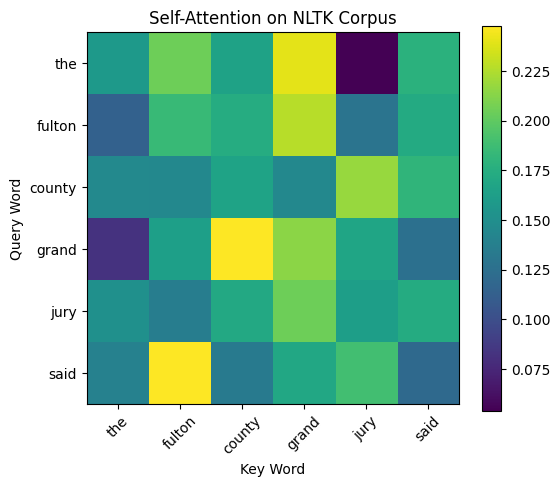


MULTI-HEAD ATTENTION
Output shape: torch.Size([1, 6, 8])
Attention weight shape: torch.Size([1, 2, 6, 6])


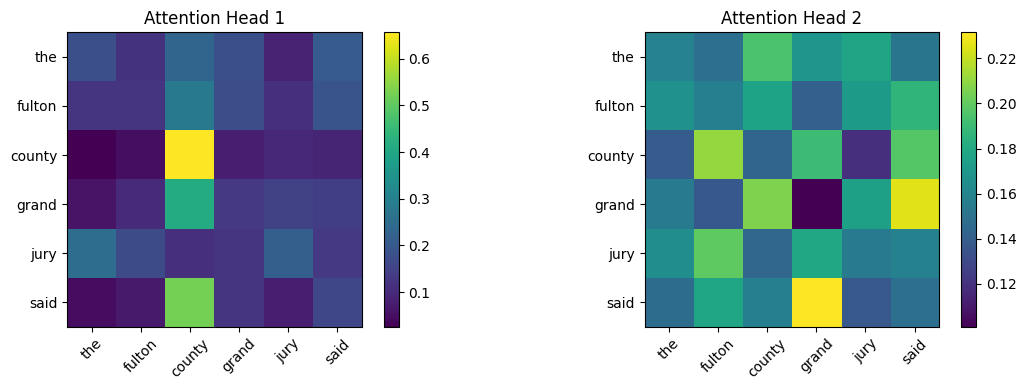

In [21]:
self_attn = SelfAttention(embed_dim=embedding_dim)
sa_output, sa_weights = self_attn(x)

print("\nSELF-ATTENTION")
print("Output shape:", sa_output.shape)
print("Attention weight shape:", sa_weights.shape)

# VISUALIZE SELF-ATTENTION
plt.figure(figsize=(6, 5))
plt.imshow(sa_weights.detach().numpy(), cmap="viridis") # Removed [0] here
plt.xticks(range(len(tokens)), tokens, rotation=45)
plt.yticks(range(len(tokens)), tokens)
plt.colorbar()

plt.title("Self-Attention on NLTK Corpus")
plt.xlabel("Key Word")
plt.ylabel("Query Word")
plt.show()
mha = MultiHeadAttention(embed_dim=embedding_dim, num_heads=2)
mha_output, mha_weights = mha(x.unsqueeze(0)) # Added .unsqueeze(0) here to add a batch dimension

print("\nMULTI-HEAD ATTENTION")
print("Output shape:", mha_output.shape)
print("Attention weight shape:", mha_weights.shape)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for h in range(2):
    im = axes[h].imshow(
        mha_weights[0, h].detach().numpy(),
        cmap="viridis"
    )
    axes[h].set_xticks(range(len(tokens)))
    axes[h].set_yticks(range(len(tokens)))
    axes[h].set_xticklabels(tokens, rotation=45)
    axes[h].set_yticklabels(tokens)
    axes[h].set_title(f"Attention Head {h+1}")
    plt.colorbar(im, ax=axes[h], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

In [23]:
mha = MultiHeadAttention(embed_dim=embedding_dim, num_heads=2)
mha_output, mha_weights = mha(x.unsqueeze(0))

print("\nMULTI-HEAD ATTENTION")
print("Output shape:", mha_output.shape)
print("Attention weight shape:", mha_weights.shape)



MULTI-HEAD ATTENTION
Output shape: torch.Size([1, 6, 8])
Attention weight shape: torch.Size([1, 2, 6, 6])


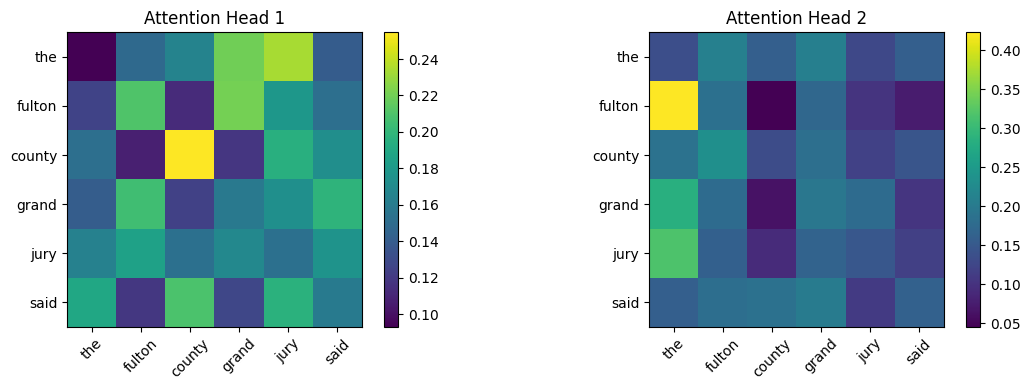

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for h in range(2):
    im = axes[h].imshow(
        mha_weights[0, h].detach().numpy(),
        cmap="viridis"
    )
    axes[h].set_xticks(range(len(tokens)))
    axes[h].set_yticks(range(len(tokens)))
    axes[h].set_xticklabels(tokens, rotation=45)
    axes[h].set_yticklabels(tokens)
    axes[h].set_title(f"Attention Head {h+1}")

    # ADD COLORBAR (SCALING VALUES) FOR EACH HEAD
    plt.colorbar(im, ax=axes[h], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

In [25]:
print("\nFINAL OBSERVATION:")
print("- Attention is applied on real corpus words")
print("- Self-attention produces ONE attention map")
print("- Multi-head attention produces MULTIPLE maps")
print("- Different heads capture different relationships")
print("- This is the core idea behind Transformers")


FINAL OBSERVATION:
- Attention is applied on real corpus words
- Self-attention produces ONE attention map
- Multi-head attention produces MULTIPLE maps
- Different heads capture different relationships
- This is the core idea behind Transformers
